In [1]:
import sys
import os
import json
from collections import Counter, OrderedDict
import re
import numpy as np
import pandas as pd
import itertools
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, datestr2num
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d, pchip_interpolate

path_to_data = "/Users/joshuabailey/Documents/ri_trackers/tests/data/Original/reddit_wallstreetbets.json"
SEMTAG_DESCRIPTION = "/Users/joshuabailey/Documents/ri_trackers/tests/data/ri_nlp_lexicons_semtag_descriptions.json"

# To-Do
- create splines to make the vis look a bit better

In [2]:
def create_list_of_sem_tags(data: dict) -> list:
    sem_list = []
    for d in data:
        for s in range(len(d["sentences"])):
            for t in range(len(d["sentences"][s]["tags"])):
                sem_list.append(d["sentences"][s]["tags"][t]["sem_tag"])
    return sem_list

def create_list_of_tokens(data: dict) -> list:
    tokens_list = []
    for d in data:
        for s in range(len(d["sentences"])):
            for t in range(len(d["sentences"][s]["tags"])):
                tokens_list.append(d["sentences"][s]["tags"][t]["word"])
    return tokens_list

def load_jsons(path_to_json):
    jsons = {}
    with open(os.path.join(path_to_json)) as json_file:
        json_text = json.load(json_file)
    return json_text

def create_list_of_list_of_sematags(jsons):
    semtag_list_of_lists = []
    for js in jsons:
        semtags = create_list_of_sem_tags(js)
        semtag_list_of_lists.append(semtags)
    return semtag_list_of_lists

def create_list_of_list_of_tokens(jsons):
    tokens_list_of_lists = []
    for js in jsons:
        tokens = create_list_of_tokens(js)
        tokens_list_of_lists.append(tokens)
    return tokens_list_of_lists

def create_list_of_list_of_freq_list(list_of_lists):
    freq_list_of_lists = []
    for sl in list_of_lists:
        freq_list = create_freq_list(sl)
        freq_list_of_lists.append(freq_list)
    return freq_list_of_lists

def create_freq_list(values: list) -> dict:
    freq_list = {p: [f,f/len(values)] for p, f in Counter(values).items()}
    return freq_list

def build_lists_of_trackable_values(jsons, list_of_filenames):
    semtag_list_of_lists = []
    tokens_list_of_lists = []
    for i, val in enumerate(list_of_filenames):
        semtags = create_list_of_sem_tags(jsons[val])
        tokens = create_list_of_tokens(jsons[val])
        semtag_list_of_lists.append(semtags)
        tokens_list_of_lists.append(tokens)
    return semtag_list_of_lists, tokens_list_of_lists

def get_rf_for_value(list_of_freq_lists: list, value: str, split_by: list):
    """
    creates the key-value pair for the date and relative frequency (rf) of each token/semtag passed into it
    """
    dict_of_vals = {}
    for i, list_ in enumerate(list_of_freq_lists):
        if value in list_:
            v = list_[value][1]
            dict_of_vals[split_by[i]] = v
        else:
            dict_of_vals[split_by[i]] = 0
    return dict_of_vals

def build_value_response(freq_list, vocab, split_by):
    """
    creates the final response for the tokens/semtags to be used in the visualisation method
    """
    all_rf_value_dicts = {}
    for val in vocab:
        all_rf_value_dicts[val] = {'data': get_rf_for_value(freq_list, val, split_by),
                                   'meta': {
                                       'split': [val],
                                       'trend': ''
                                   }
                                  }
    return all_rf_value_dicts

def bucket_responses(response, bucket_name, split_by, aggregation, *args):
    """
    given a list of tokens/semtags to create into a new grouping, group them together and return a new response with
    the new grouping.
    
    This will also add args to the split list which is used in the visualisation method to split out the values
    """
    if aggregation == "cumulative":
        bucketed_dict = {}
        for arg in args:
            for i in range(len(split_by)):
                bucketed_dict[split_by[i]] = 0

        for arg in args:
            for i in range(len(split_by)):
                bucketed_dict[split_by[i]] += response[arg]["data"][split_by[i]]
        return {
            bucket_name: {'data': bucketed_dict,
                          'meta': {
                              'split': list(args),
                              'trend': '',
                              'type': 'group'
                          }
                         }
                        }
    elif aggregation == "average":
        bucketed_dict = {}
        for arg in args:
            for i in range(len(split_by)):
                bucketed_dict[split_by[i]] = 0

        for arg in args:
            for i in range(len(split_by)):
                bucketed_dict[split_by[i]] += response[arg]["data"][split_by[i]]
            
        for i in range(len(split_by)):
            bucketed_dict[split_by[i]] = bucketed_dict[split_by[i]]/len(list(args))
        
        return {
            bucket_name: {'data': bucketed_dict,
                          'meta': {
                              'split': list(args),
                              'trend': '',
                              'type': 'group'
                          }
                         }
                        }
        

def calculate_trend(moving_averages):
    X = np.arange(0, len(moving_averages), 1).reshape(-1, 1)
    y = np.array(moving_averages[0:len(moving_averages)]).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0,0]

In [3]:
"""
TODO: Create a function which is able to also bucket these by date, month, year. 


Below is code which gets the first day of each week. This could be used to transform the date in the
message object to the first day for each week/month/year, check if the bucket exists and then place 
the message in week/month/year bucket.

import datetime
import time

first_day_of_weeks = []
for year, week, day in week_num:
    firstdayofweek = datetime.datetime.strptime(f'{year}-W{int(week)- 1}-1', "%Y-W%W-%w").date()
    firstdayofweek = datetime.datetime.strftime(firstdayofweek, '%Y-%m-%d')
    if firstdayofweek in first_day_of_weeks:
        pass
    else:
        first_day_of_weeks.append(firstdayofweek)

"""
def bucket_dates(json, bucket_type = 'day'):
    dict_of_messages = json.copy()
    dates = []
    for m in dict_of_messages:
        m['meta']['date'] = m['meta']['date'].split("T")[0] # for now just looking at daily data
        dates.append(m['meta']['date'])
    date_list = list(set(dates))
        
    if bucket_type == 'day':
        new_dict = {d: [] for d in dates} # Initialises a dictionary for data to be stored for each date
        for m in dict_of_messages:
            new_dict[m['meta']['date']].append(m) #for each date we bucket the messages with the corresponding date to create multiple aggregated lists
        
        return new_dict, date_list
    
    elif bucket_type == 'week':
        date_tuples = []
        for date in date_list:
            num = datetime.datetime.strptime(date, '%Y-%m-%d').isocalendar()
            if num in date_tuples:
                pass
            else:
                date_tuples.append(num)
                
        first_day_of_weeks = []
        for year, week, day in date_tuples:
            firstdayofweek = datetime.datetime.strptime(f'{year}-W{int(week)- 1}-1', "%Y-W%W-%w").date()
            firstdayofweek = datetime.datetime.strftime(firstdayofweek, '%Y-%m-%d')
            if firstdayofweek in first_day_of_weeks:
                pass
            else:
                first_day_of_weeks.append(firstdayofweek)
        
        new_dict = {d: [] for d in first_day_of_weeks}
        for m in dict_of_messages:
            year, week, day = datetime.datetime.strptime(m['meta']['date'], '%Y-%m-%d').isocalendar()
            firstdayofweek = datetime.datetime.strptime(f'{year}-W{int(week)- 1}-1', "%Y-W%W-%w").date()
            firstdayofweek = datetime.datetime.strftime(firstdayofweek, '%Y-%m-%d')
            new_dict[firstdayofweek].append(m)
        
        return new_dict, list(new_dict.keys())
    
    elif bucket_type == 'month':
        dates = []
        for m in dict_of_messages:
            m['meta']['date'] = datetime.datetime.strptime(m['meta']['date'], '%Y-%m-%d').strftime("%Y-%m-01")
            dates.append(m['meta']['date'])
            
        date_list_2 = list(set(dates))
        
        new_dict = {d: [] for d in date_list_2}
        for m in dict_of_messages:
            new_dict[m['meta']['date']].append(m)
        
        return new_dict, list(new_dict.keys())


In [4]:
def calculate_moving_averages(tracked_values: list, 
                              response: dict,
                              window_size = 5):
    """
    Calculates the moving moving average given a window_size
    """
    all_moving_averages = []
    for val in tracked_values:
        ordered = OrderedDict(sorted(response[val]["data"].items()))
        values = list(ordered.values())
        i = 0
        moving_averages = []

        while i < len(values) - window_size + 1:
            this_window = values[i : i + window_size]
            window_average = sum(this_window) / window_size
            moving_averages.append(window_average)
            i += 1
        all_moving_averages.append(moving_averages)
        
    return all_moving_averages


In [5]:
def every_date(date_list, time_bucket = 'day'):
    dates_transformed = []

    for d in set(date_list):
        date_time_obj = datetime.datetime.strptime(d, '%Y-%m-%d')
        dates_transformed.append(date_time_obj)

    last_date = max(dates_transformed)
    first_date = min(dates_transformed)

    date = last_date - first_date
    if time_bucket == 'day':
        every_date = [last_date - datetime.timedelta(days=x) for x in range(0, date.days+3)]
        every_date = [date.strftime("%Y-%m-%d") for date in every_date]
    elif time_bucket == 'week':
        every_date = [last_date - datetime.timedelta(days=x) for x in range(0, date.days+1, 7)]
        every_date = [date.strftime("%Y-%m-%d") for date in every_date]
    else:
        pass
    
    every_date.sort()
    
    return every_date


In [6]:
def build_lists_of_trackable_values(jsons):
    """
    creates a list of lists of tokens and semtags to be used to track. This list of lists will be the length of the 
    number of dates in the original response as each list will correspond to a different date - this way the 
    frequency lists can be calculated within each date rather than from the entire language set.
    """
    semtag_list_of_lists = []
    tokens_list_of_lists = []
    for i, val in enumerate(jsons):
        semtags = create_list_of_sem_tags(jsons[val])
        tokens = create_list_of_tokens(jsons[val])
        semtag_list_of_lists.append(semtags)
        tokens_list_of_lists.append(tokens)
    return semtag_list_of_lists, tokens_list_of_lists

In [7]:
def build_vocabulary(list_of_lists):
    flat =itertools.chain.from_iterable(list_of_lists)
    vocab = list(set(flat))
    return vocab

In [8]:
def build_full_range_of_dates(response, date_list):
    """
    Takes the date_list we created earlier that has the entire range of dates and updates the data dictionary in the response to reflect this
    """
    for i, val in enumerate(response):
        for j, date in enumerate(date_list):
            if date in list(response[val]["data"].keys()):
                pass
            else:
                response[val]["data"][date] = 0
    return response


In [9]:
def update_type_meta_key(response):
    for key in response:
        if key in list(SEMTAGS.keys()):
            response[key]["meta"]["type"] = "semtag"
        else:
            response[key]["meta"]["type"] = "token"


In [10]:
def make_graph_spline(list_of_vals, response, window_size, date_list):
    """
    Graph to visualise the tracked values - the larger the window size, the smoother and less sensitive to noise the graph is
    """
    all_moving_averages = calculate_moving_averages(list_of_vals, response, window_size)
    fig, ax = plt.subplots(figsize=(16, 12))
    plt.xticks(rotation = 45)
    lines = []
    x_dates = np.array([datestr2num(i) for i in date_list])
    x_dates.sort()
                       
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in date_list]
    x_values.sort()
    
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(locator)
    ax.set_ylim(bottom=0, auto=True)
    
    for i, ma in enumerate(all_moving_averages):
        if list_of_vals[i] in list(SEMTAGS.keys()):
            x_smooth = np.linspace(x_dates.min(), x_dates.max(), 500)
            y_smooth = pchip_interpolate(x_dates[window_size-1:len(date_list)], ma, x_smooth)
            y_smooth[y_smooth<0] = 0
            lines += ax.plot(x_smooth, y_smooth, label = "{}".format(SEMTAGS[list_of_vals[i]]))
        else:
            x_smooth = np.linspace(x_dates.min(), x_dates.max(), 500)
            y_smooth = pchip_interpolate(x_dates[window_size-1:len(date_list)], ma, x_smooth)
            y_smooth[y_smooth<0] = 0
            lines += ax.plot(x_smooth, y_smooth, label = "{}".format(list_of_vals[i]))
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels)

In [11]:
def make_graph(list_of_vals, response, window_size, date_list):
    """
    Graph to visualise the tracked values - the larger the window size, the smoother and less sensitive to noise the graph is
    """
    all_moving_averages = calculate_moving_averages(list_of_vals, response, window_size)
    fig, ax = plt.subplots(figsize=(16, 12))
    plt.xticks(rotation = 45)
    lines = []
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in date_list]
    x_values.sort()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(locator)
    
    
    for i, ma in enumerate(all_moving_averages):
        if list_of_vals[i] in list(SEMTAGS.keys()):
            lines += ax.plot(x_values[window_size-1:len(date_list)], ma, label = "{}".format(SEMTAGS[list_of_vals[i]]))
        else:
            lines += ax.plot(x_values[window_size-1:len(date_list)], ma, label = "{}".format(list_of_vals[i]))
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels)

In [12]:
def visualise_tracked_values(
                            tracked_values:list, 
                            response: dict, 
                            date_list: list, 
                            window_size = 7, 
                            split = False,
                            spline = False):
    
    if spline == True:
        if split == True:
            new_tracked_values = []
            for i, val in enumerate(tracked_values):
                if len(tracked_values) > 1:
                    new_tracked_values.append(response[val]["meta"]["split"])
                else:
                    new_tracked_values = [i for i in response[val]["meta"]["split"]]
                    make_graph_spline(new_tracked_values, response, window_size, date_list)

            if len(tracked_values) > 1:      
                unrolled_list = []
                for i in new_tracked_values:
                    for j in i:
                        unrolled_list.append(j)
                make_graph_spline(unrolled_list, response, window_size, date_list)

        else:
            make_graph_spline(tracked_values, response, window_size, date_list)
    else:
        if split == True:
            new_tracked_values = []
            for i, val in enumerate(tracked_values):
                if len(tracked_values) > 1:
                    new_tracked_values.append(response[val]["meta"]["split"])
                else:
                    new_tracked_values = [i for i in response[val]["meta"]["split"]]
                    make_graph(new_tracked_values, response, window_size, date_list)

            if len(tracked_values) > 1:      
                unrolled_list = []
                for i in new_tracked_values:
                    for j in i:
                        unrolled_list.append(j)
                make_graph(unrolled_list, response, window_size, date_list)

        else:
            make_graph(tracked_values, response, window_size, date_list)
        


In [13]:
def naive_trend_calculation(values_to_visualise, response, window_size=5, split=False):
    list_of_list_of_vals = []
    list_of_tracked_values = []
    if split:
        for val in values_to_visualise:
            new_tracked_values = [i for i in response[val]["meta"]["split"]]
            list_of_tracked_values.append(new_tracked_values)
        tracked_values = list(itertools.chain.from_iterable(list_of_tracked_values))
        moving_averages = calculate_moving_averages(tracked_values, response, window_size)
        print(len(tracked_values))
        for i, list_ in enumerate(moving_averages):
            vals = []
            for j, _ in enumerate(moving_averages[i]):
                if j == 0:
                    v = 0
                    vals.append(v)
                else:
                    v = (moving_averages[i][j] - moving_averages[i][j-1])
                    vals.append(v)
            list_of_list_of_vals.append(vals)
        
    
        for i, v in enumerate(tracked_values):
            print("Updating trend for {}".format(v))
            print(moving_averages[i][-1] - moving_averages[i][-window_size])
            if moving_averages[i][-1] - moving_averages[i][-window_size] > 0:
                trend = "positive"
                response[v]["meta"]["trend"] = trend
            elif moving_averages[i][-1] - moving_averages[i][-window_size] == 0:
                trend = "no trend"
                response[v]["meta"]["trend"] = trend
            else:
                trend = "negative"
                response[v]["meta"]["trend"] = trend
            print(trend)

    else:
        moving_averages = calculate_moving_averages(values_to_visualise, response, window_size)
        for i, list_ in enumerate(moving_averages):
            vals = []
            for j, _ in enumerate(moving_averages[i]):
                if j == 0:
                    v = 0
                    vals.append(v)
                else:
                    v = (moving_averages[i][j] - moving_averages[i][j-1])
                    vals.append(v)
            list_of_list_of_vals.append(vals)
            
        for i, v in enumerate(values_to_visualise):
            print("Updating trend for {}".format(v))
            print(moving_averages[i][-1] - moving_averages[i][-window_size])
            if moving_averages[i][-1] - moving_averages[i][-window_size] > 0:
                trend = "positive"
                response[v]["meta"]["trend"] = trend
            elif moving_averages[i][-1] - moving_averages[i][-window_size] == 0:
                trend = "no trend"
                response[v]["meta"]["trend"] = trend
            else:
                trend = "negative"
                response[v]["meta"]["trend"] = trend
            print(trend)
        
        

In [14]:
"""
---- Needs to be looked at ----
"""

def linear_regression_trend_calculation(values_to_visualise, response, window_size=5, split=False):
    """
    TODO: Velocity of trend, splines
    """
    list_of_list_of_vals = []
    list_of_tracked_values = []
    if split:
        for val in values_to_visualise:
            new_tracked_values = [i for i in response[val]["meta"]["split"]]
            list_of_tracked_values.append(new_tracked_values)       
        tracked_values = list(itertools.chain.from_iterable(list_of_tracked_values))
        moving_averages = calculate_moving_averages(tracked_values, response, window_size)
        for i, v in enumerate(tracked_values):
            coeff = calculate_trend(moving_averages[i])
            print("Updating trend for {}".format(v))
            print("Coefficient is {}".format(coeff))
            if coeff > 0:
                trend = "positive"
                response[v]["meta"]["trend"] = trend
            elif coeff == 0:
                trend = "no trend"
            else:
                trend = "negative"
                response[v]["meta"]["trend"] = trend
            print(trend)

    else:
        moving_averages = calculate_moving_averages(values_to_visualise, response, window_size)
        for i, v in enumerate(values_to_visualise):
            coeff = calculate_trend(moving_averages[i])
            print("Updating trend for {}".format(v))
            print("Coefficient is {}".format(coeff))
            if coeff > 0:
                trend = "positive"
                response[v]["meta"]["trend"] = trend
            elif coeff == 0:
                trend = "no trend"
            else:
                trend = "negative"
                response[v]["meta"]["trend"] = trend
            print(trend)
        

In [15]:
jsons = load_jsons(path_to_data)

In [16]:
type(jsons)

list

In [16]:
import time

start_time = time.time()

dict_of_messages_day, all_date_list_day = bucket_dates(jsons, 'day')
dict_of_messages_week, all_date_list_week = bucket_dates(jsons, 'week')
dict_of_messages_month, all_date_list_month = bucket_dates(jsons, 'month')

In [17]:
all_dates_day = every_date(all_date_list_day, 'day')
all_dates_week = every_date(all_date_list_week, 'week')
len(all_dates_day)

399

In [18]:
semtag_list_of_lists_day, tokens_list_of_lists_day = build_lists_of_trackable_values(dict_of_messages_day)
semtag_list_of_lists_week, tokens_list_of_lists_week = build_lists_of_trackable_values(dict_of_messages_week)
semtag_list_of_lists_month, tokens_list_of_lists_month = build_lists_of_trackable_values(dict_of_messages_month)

In [19]:
tokens_freq_list_day = create_list_of_list_of_freq_list(tokens_list_of_lists_day)
tokens_freq_list_week = create_list_of_list_of_freq_list(tokens_list_of_lists_week)
tokens_freq_list_month = create_list_of_list_of_freq_list(tokens_list_of_lists_month)

In [20]:
semtag_freq_list_day = create_list_of_list_of_freq_list(semtag_list_of_lists_day)
semtag_freq_list_week = create_list_of_list_of_freq_list(semtag_list_of_lists_week)
semtag_freq_list_month = create_list_of_list_of_freq_list(semtag_list_of_lists_month)

In [21]:
token_vocab = build_vocabulary(tokens_list_of_lists_day)
semtag_vocab = build_vocabulary(semtag_list_of_lists_day)

In [22]:
token_response_day = build_value_response(tokens_freq_list_day, token_vocab, all_date_list_day)
token_response_week = build_value_response(tokens_freq_list_week, token_vocab, all_date_list_week)
token_response_month = build_value_response(tokens_freq_list_month, token_vocab, all_date_list_month)

In [23]:
semtag_response_day = build_value_response(semtag_freq_list_day, semtag_vocab, all_date_list_day)
semtag_response_week = build_value_response(semtag_freq_list_week, semtag_vocab, all_date_list_week)
semtag_response_month = build_value_response(semtag_freq_list_month, semtag_vocab, all_date_list_month)

In [24]:
token_response_day = build_full_range_of_dates(token_response_day, all_dates_day)
token_response_week = build_full_range_of_dates(token_response_week, all_dates_week)

In [25]:
semtag_response_day = build_full_range_of_dates(semtag_response_day, all_dates_day)
semtag_response_week = build_full_range_of_dates(semtag_response_week, all_dates_week)

In [26]:
token_response_day.update(semtag_response_day)
token_response_week.update(semtag_response_week)
token_response_month.update(semtag_response_month)

In [27]:
with open(os.path.join(SEMTAG_DESCRIPTION)) as json_file:
    SEMTAGS = json.load(json_file)

In [28]:
update_type_meta_key(token_response_day)
update_type_meta_key(token_response_week)
update_type_meta_key(token_response_month)

In [39]:
#Creating a new group and adding it to the response.
list_to_bucket = [
    #'A5',
    'A5.1',
    'A5.1+',
    'A5.1-',
    #'A5.2',
    'A5.2+',
    'A5.2-',
    'A5.3',
    'A5.3+',
    'A5.3-',
    #'A5.4',
    'A5.4+',
    'A5.4-',
    "evaluation"
]

bucket_name = "All Evaluations"
token_response_day.update(bucket_responses(token_response_day, bucket_name, all_dates_day, "average", *list_to_bucket))
token_response_week.update(bucket_responses(token_response_week, bucket_name, all_dates_week, "average", *list_to_bucket))
token_response_month.update(bucket_responses(token_response_month, bucket_name, all_date_list_month, "average", *list_to_bucket))


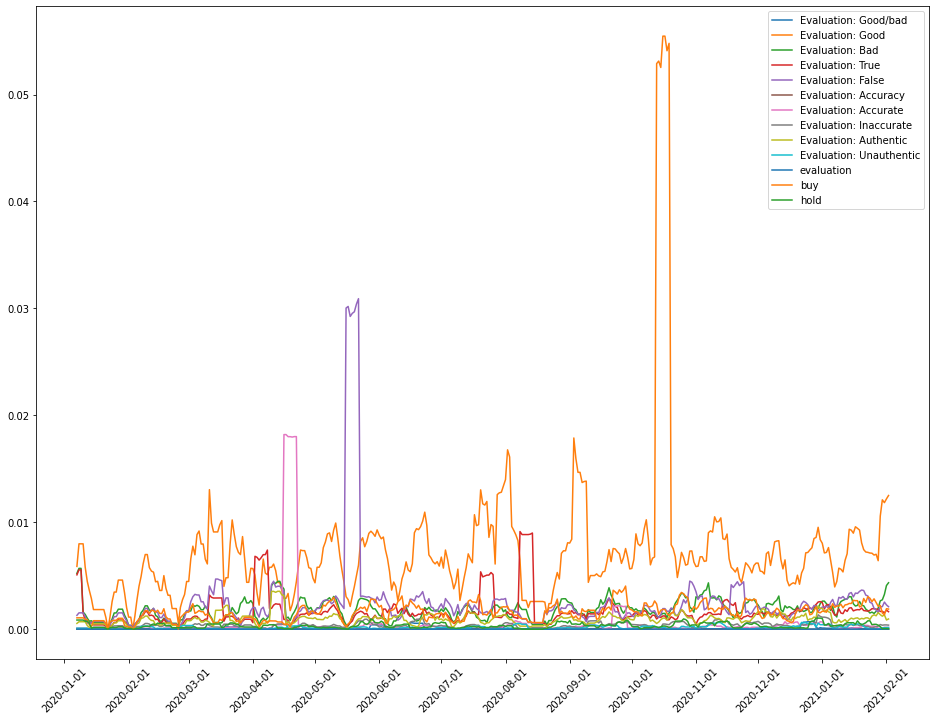

In [72]:
# Daily Demo
values_to_visualise = [
    'All Evaluations',
    'buy',
    'hold'
                 ]
window_size = 7
visualise_tracked_values(
                        values_to_visualise, 
                        token_response_day, 
                        all_dates_day, 
                        window_size=window_size, 
                        split=True,
                        spline=False
                        )


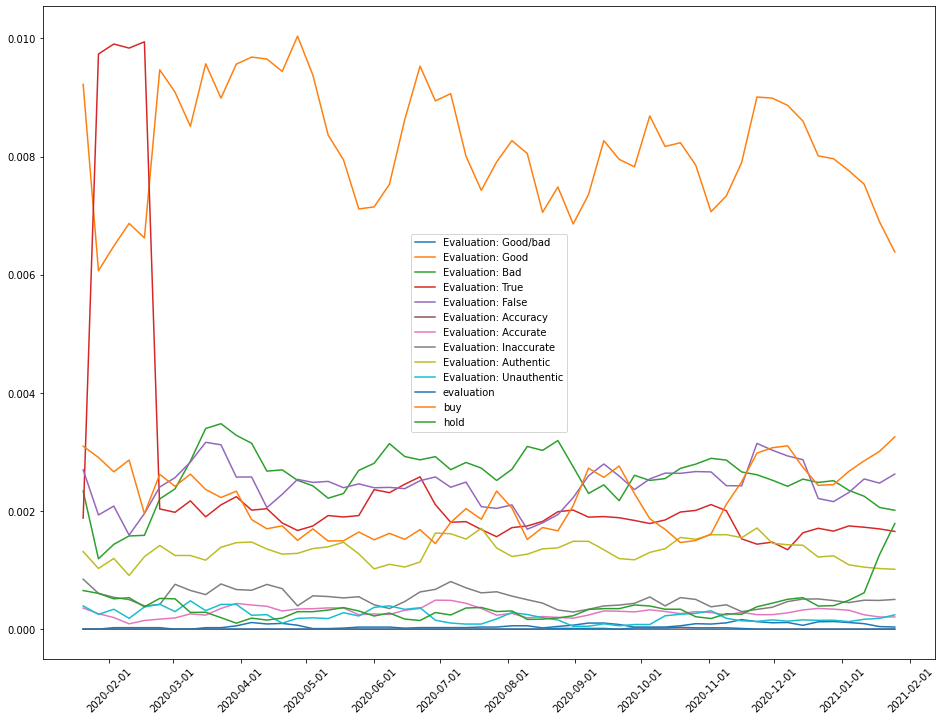

In [75]:
# Weekly Demo
window_size = 4
visualise_tracked_values(
                        values_to_visualise, 
                        token_response_week, 
                        all_dates_week, 
                        window_size=window_size, 
                        split=True,
                        spline = False
                        )

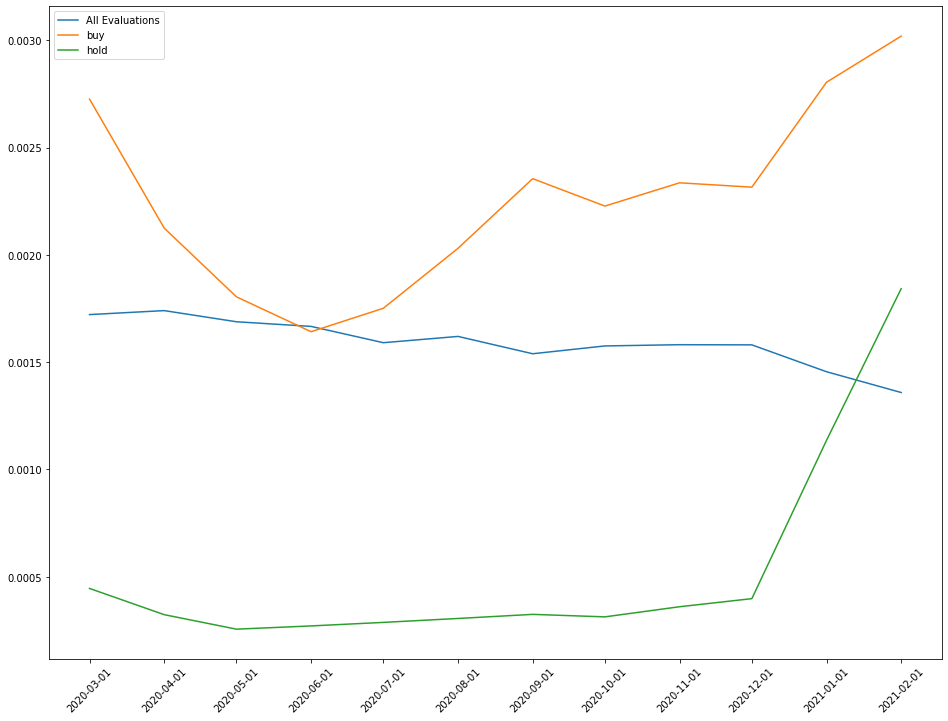

In [77]:
window_size = 3
visualise_tracked_values(
                        values_to_visualise, 
                        token_response_month, 
                        all_date_list_month, 
                        window_size=window_size, 
                        split=False,
                        spline=False
                        )


Below is the WIP for a naive trend score - rather than building out a full linear regression I thought a naive trend score would be easier to implement for now.

In [78]:
linear_regression_trend_calculation(["All Evaluations"], token_response_day, window_size, split = False)

Updating trend for All Evaluations
Coefficient is 1.4970910537930004e-06
positive


In [ ]:
len(all_dates_week)

In [ ]:
list(semtag_response_day.keys())